In [1]:


import tensorflow as tf
import deepxde as dde
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm, lognorm
import xarray as xr
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import pandas as pd

dde.config.set_default_float("float32")


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Set the default float type to float32


In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
FIGURE_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Code/figures/"
DATA_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/"
DATA_LOAD_PATH = DATA_PATH + "original_data/"
INPUT_MODEL_PATH = DATA_PATH + "processed_data/"
MODEL_SAVE_PATH = DATA_PATH + "trained_models/"
RESULTS_PATH = DATA_PATH + "model_results/"
path_to_shapefile = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/ne_110m_admin_0_countries.shp"
world = gpd.read_file(path_to_shapefile)

In [4]:
with open("functions_training_model.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

In [5]:
df_empirical_Holocene = pd.read_csv(INPUT_MODEL_PATH + "df_empirical_Holocene.csv")
df_global_grid = pd.read_csv(INPUT_MODEL_PATH + "df_global_grid.csv")
df_wind = pd.read_csv(INPUT_MODEL_PATH + "df_wind.csv", usecols=['wind', 'latitude'])

latitude_wind, mean_wind = df_wind['latitude'].values / 90, df_wind['wind'].values / df_wind['wind'].max()


def wind_latitude(latitude):
    interpolated = wind_tf_interp(latitude, tf.convert_to_tensor(latitude_wind), tf.convert_to_tensor(mean_wind))
    return interpolated


tf_wind_latitude = tf.function(wind_latitude)


In [6]:
def training_points(df):
    data_observ_points = dde.data.DataSet(
        X_train=df[['lon', 'lat']].values / 90,
        y_train=df['log_dep_norm'].values.reshape(-1, 1),
        X_test=df[['lon', 'lat']].values / 90,
        y_test=df['log_dep_norm'].values.reshape(-1, 1),
        standardize=False)

    observe_u = dde.icbc.PointSetBC(data_observ_points.train_x,
                                    df['log_dep_norm'].values.reshape(-1, 1), component=0)

    return data_observ_points, observe_u

In [7]:
x_min, x_max = -2.0, 2.0
y_min, y_max = -0.89, 0.89

left_corner = np.array([x_min, y_min])  # xmin, ymin – Coordinate of bottom left corner.
right_corner = np.array([x_max, y_max])  # xmax, ymax – Coordinate of top right corner.
geometry_rectangle = dde.geometry.geometry_2d.Rectangle(left_corner, right_corner)

# Reduce the training domain to avoid pole singularities.
#df_empirical_Holocene_2 = df_empirical_Holocene[
 #   (df_empirical_Holocene['lat'] >= -81) & (df_empirical_Holocene['lat'] <= 81)]


In [8]:
D = dde.Variable(1.0)
def pde(x, u):
    du_x = dde.grad.jacobian(u, x, j=0)  # du/dlambda
    du_y = dde.grad.jacobian(u, x, j=1)  # du/dtheta

    K = wind_latitude(x[:, 1:2])
    K = tf.cast(K, tf.float32)

    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # d^2u/dlambda^2
    du_yy = dde.grad.hessian(u, x, i=1, j=1)  # d^2u/dtheta^2

    return (
        (-K * du_x * (1 / tf.cos(x[:, 1:2] * np.pi / 2)) + D * (
            (1 / (tf.cos(x[:, 1:2] * np.pi / 2) ** 2) * du_xx + du_yy - tf.tan(x[:, 1:2] * np.pi / 2) * du_y)))
    )

In [9]:
def space_boundary_north(x, on_boundary):
    return on_boundary and np.isclose(y_max, x[1])


def space_boundary_south(x, on_boundary):
    return on_boundary and np.isclose(y_min, x[1])


def periodic_boundary(x, domain):
    return domain and (np.isclose(x[0], x_min) or np.isclose(x[0], x_max))

In [10]:
def train_process(data_observ_points, observe_u, D, bc_1, bc_2, model_name):
    data = dde.data.PDE(
        geometry_rectangle,
        pde,
        [observe_u, periodic_condition, periodic_condition_derivative, bc_1, bc_2],
        num_domain=2592,
        num_boundary=216,
        anchors=data_observ_points.train_x,
        train_distribution='uniform'
    )
    neurons = 67
    layer = 7
    layer_size = [2] + [neurons] * layer + [1]
    activation = "selu"
    initializer = "Glorot normal"
    net = dde.maps.FNN(layer_size, activation, initializer)
    model = dde.Model(data, net)
    dde.optimizers.set_LBFGS_options(maxcor=50, ftol=1e-20, maxiter=1e5)
    model.compile("adam", lr=0.00001, external_trainable_variables=[D, north_mean, south_mean],
                  loss_weights=[1, 1, 1, 1, 1, 1])
                  #loss_weights=[5, 10, 0.5, 0.5, 1, 1])

    # Train and save the model
    import os
    os.makedirs(MODEL_SAVE_PATH + model_name, exist_ok=True)

    checkpointer = dde.callbacks.ModelCheckpoint(
        f"{MODEL_SAVE_PATH}{model_name}/{model_name}.ckpt",
        verbose=0, period=10000,
    )

    variable = dde.callbacks.VariableValue([D, north_mean, south_mean], period=10000,
                                           filename=MODEL_SAVE_PATH + model_name + "/variables.dat")

    losshistory, train_state = model.train(epochs=15000, callbacks=[variable, checkpointer])
    dde.saveplot(losshistory, train_state, issave=False, isplot=True)
    params = variable.get_value()

    return model, params, train_state.best_step, losshistory

In [11]:
north_mean = dde.Variable(-1.0)
south_mean = dde.Variable(-2.0)
D = dde.Variable(1.0)

bc_1 = dde.DirichletBC(geometry_rectangle, lambda x: north_mean, space_boundary_north)
bc_2 = dde.DirichletBC(geometry_rectangle, lambda x: south_mean, space_boundary_south)

periodic_condition = dde.icbc.PeriodicBC(geom=geometry_rectangle, component_x=0, on_boundary=periodic_boundary,
                                         derivative_order=0)
periodic_condition_derivative = dde.icbc.PeriodicBC(geom=geometry_rectangle, component_x=0,
                                                    on_boundary=periodic_boundary, derivative_order=1)


Compiling model...
Building feed-forward neural network...
'build' took 0.155701 s


'compile' took 2.056289 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.53e+02, 5.08e+00, 1.76e+01, 2.43e-01, 2.13e+00, 6.20e+00]    [2.53e+02, 5.08e+00, 1.76e+01, 2.43e-01, 2.13e+00, 6.20e+00]    []  
1000      [4.09e+00, 1.13e+00, 2.94e-02, 3.72e-02, 3.98e-01, 1.04e+00]    [4.09e+00, 1.13e+00, 2.94e-02, 3.72e-02, 3.98e-01, 1.04e+00]    []  
2000      [1.45e+00, 1.46e+00, 3.21e-02, 1.09e-02, 9.13e-02, 4.22e-01]    [1.45e+00, 1.46e+00, 3.21e-02, 1.09e-02, 9.13e-02, 4.22e-01]    []  
3000      [1.00e+00, 1.46e+00, 2.29e-02, 9.38e-03, 8.35e-02, 2.58e-01]    [1.00e+00, 1.46e+00, 2.29e-02, 9.38e-03, 8.35e-02, 2.58e-01]    []  
4000      [6.37e-01, 1.32e+00, 2.17e-02, 9.03e-03, 1.07e-01, 1.55e-01]    [6.37e-01, 1.32e+00, 2.17e-02, 9.03e-03, 1.07e-01, 1.55e-01]    []  
5000

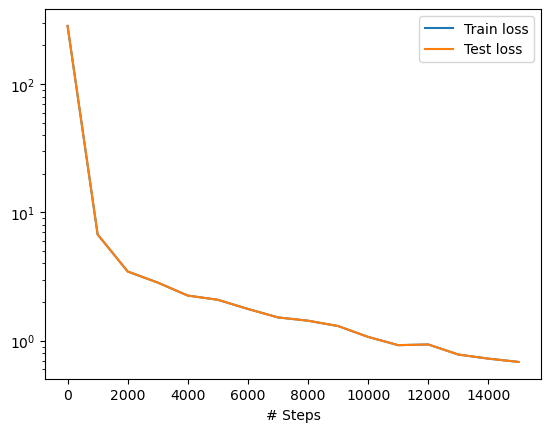

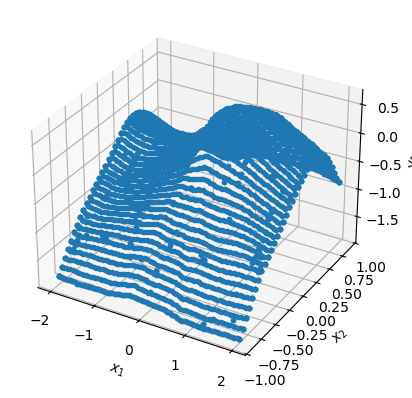

PINN MSE sulla regione: 0.4928


In [12]:
# Addestramento PINN e stima errori
# --------------------------------------------------
data_obs, bc_point = training_points(df_empirical_Holocene)
pinn_model, _, _ , losshistory= train_process(data_obs, bc_point, D, bc_1, bc_2, 'model_pinn_empirical_Holocene')
Xg = (df_empirical_Holocene[['lon', 'lat']].values / 90.0).astype(np.float32)
Yg = df_empirical_Holocene['log_dep_norm'].values.reshape(-1, 1).astype(np.float32)
pinn_g = pinn_model.predict(Xg)
mse_pinn = np.mean((pinn_g - Yg) ** 2)
print(f"PINN MSE sulla regione: {mse_pinn:.4f}")

mean = df_empirical_Holocene['log_dep'].mean()
std = df_empirical_Holocene['log_dep'].std()
pinn_g_denorm = pinn_g * std + mean
Yg_denorm = df_empirical_Holocene['log_dep'].values.reshape(-1, 1)
mse_denorm = np.mean((pinn_g_denorm - Yg_denorm) ** 2)

#print(f"PINN MSE denorm sulla regione: {mse_pinn:.4f}")


In [13]:
print(f"PINN MSE sulla regione: {mse_pinn:.4f}")
print(f"PINN MSE denorm sulla regione: {mse_denorm:.4f}")


PINN MSE sulla regione: 0.4928
PINN MSE denorm sulla regione: 0.5730


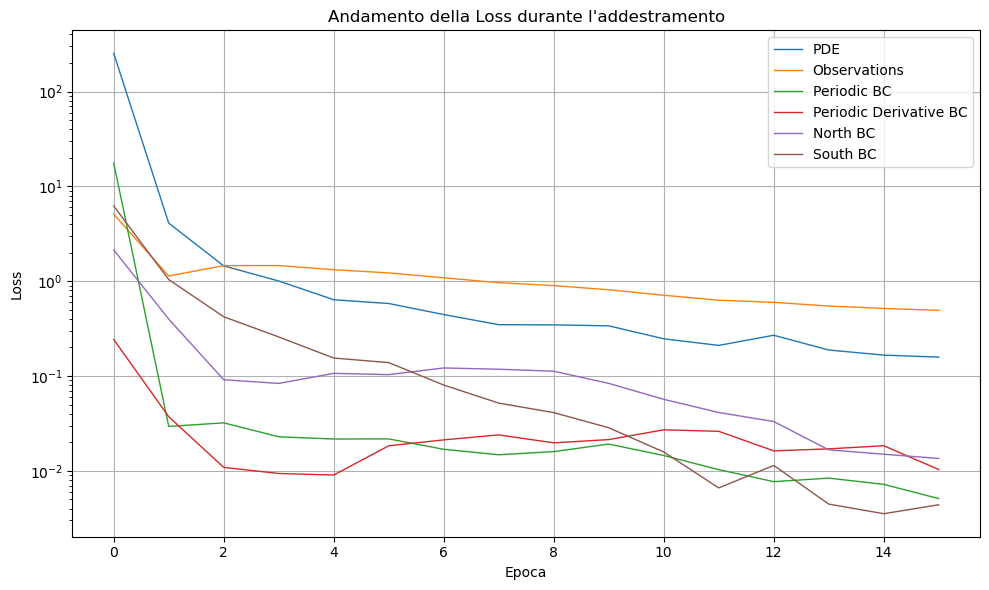

In [14]:

import matplotlib.pyplot as plt

# Estrai le epoche
epochs = range(len(losshistory.loss_train))
components = ['PDE', 'Observations', 'Periodic BC', 'Periodic Derivative BC', 'North BC', 'South BC']
# Loss totale durante il training
plt.figure(figsize=(10, 6))
for i in range(6):  # 6 componenti di loss
    plt.plot(epochs, [l[i] for l in losshistory.loss_train], label=components[i], linewidth=1)
# Se disponibile: validation loss
#if losshistory.loss_test:
#   plt.plot(epochs, losshistory.loss_test, label="Test loss")

plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.title("Andamento della Loss durante l'addestramento")
plt.yscale("log")  # utile se le loss coprono più ordini di grandezza
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.0013911184466709062
Nugget: 0.9424101330657443 



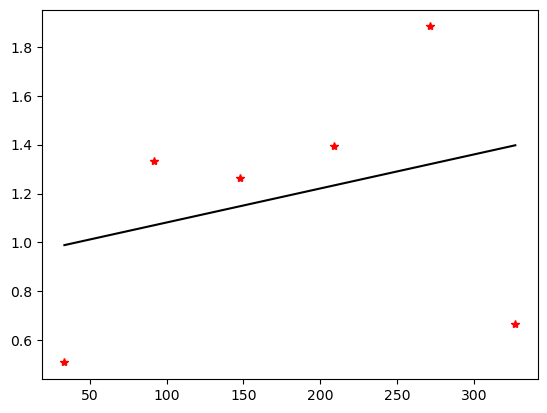

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Executing Ordinary Kriging...

MSE Kriging sui punti di training: 0.068537


In [15]:
# Kriging vettorializzato e stima errori
# --------------------------------------------------

#df_train_sampled = df_empirical_Holocene_2.drop_duplicates#(subset=['lon', 'lat']).copy()
#print(f"Punti selezionati per il training: {len(df_train_sampled)}")

# Coordinate e valori da usare per il Kriging
lon_tr = df_empirical_Holocene['lon'].values
lat_tr = df_empirical_Holocene['lat'].values
val_tr = df_empirical_Holocene['log_dep'].values

#coordinate griglia
lon_pred = df_global_grid['lon'].values
lat_pred = df_global_grid['lat'].values

# Inizializza il modello Kriging
ok = OrdinaryKriging(
    lon_tr, lat_tr, val_tr,
    variogram_model='linear', verbose=True, enable_plotting=True
)

# Esegui la predizione
krig_pred, krig_var = ok.execute('points', lon_pred, lat_pred)
# 1. per predire con Kriging MSE
krig_pred_train, _ = ok.execute('points', lon_tr, lat_tr)
mse_kriging = np.mean((krig_pred_train - val_tr) ** 2)

print(f"MSE Kriging sui punti di training: {mse_kriging:.6f}")




In [16]:
with open("functions_plot_calculations.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)

In [17]:
# creo una griglia 1°x1°
# Definisci i range
lon_vals = np.arange(-180, 180, 1)  # Include 180
lat_vals = np.arange(-90, 90, 1)  # Include 90

# Crea la griglia con tutti i punti (lon, lat)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# Crea il DataFrame
df_global_grid_1x1 = pd.DataFrame({
    'lon': lon_flat,
    'lat': lat_flat
})

print(f"Griglia creata con {len(df_global_grid_1x1)} punti")

# Opzionale: salva su CSV
#df_global_grid_1x1.to_csv("global_grid_1x1.csv", index=False)


Griglia creata con 64800 punti


In [18]:
def calculate_save_df(model, df_to_predict, mean, std, path, filename):
    "Perform the predictions and save the results."
    U_pred = model.predict(df_to_predict[['lon', 'lat']].values / 90)
    U_pred_denorm = (U_pred * std) + mean
    df_to_predict['PINN_log_dep'] = U_pred_denorm
    df_to_predict.to_csv(path + filename, index=False)


def calculate_save_kriging_df(ok_model, df_to_predict, path, filename):
    """
    Esegue la predizione con Kriging su df_to_predict e salva il risultato.
    ok_model: oggetto OrdinaryKriging già addestrato
    df_to_predict: DataFrame con colonne 'lon' e 'lat'
    """
    # Esegui predizione (già in scala originale)
    krig_arr, _ = ok_model.execute('points', df_to_predict['lon'].values, df_to_predict['lat'].values)

    # Aggiungi la colonna al DataFrame (senza denormalizzazione!)
    df_to_predict['Kriging_log_dep'] = krig_arr

    # Salva il risultato
    df_to_predict.to_csv(path + filename, index=False)

mean = df_empirical_Holocene['log_dep'].mean()
std = df_empirical_Holocene['log_dep'].std()


calculate_save_df(pinn_model, df_empirical_Holocene, mean, std, RESULTS_PATH, "df_pinn_empirical_bands.csv")
calculate_save_df(pinn_model, df_global_grid, mean, std, RESULTS_PATH, "df_pinn_empirical_Holocene_global_grid.csv")
calculate_save_df(pinn_model, df_global_grid_1x1, mean, std, RESULTS_PATH, "df_pinn_empirical_Holocene_global_grid1x1.csv")
calculate_save_kriging_df(ok, df_empirical_Holocene, RESULTS_PATH, "df_kriging_empirical_bands.csv")
calculate_save_kriging_df(ok, df_global_grid, RESULTS_PATH, "df_kriging_empirical_global grid.csv")

Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [19]:
df_pinn_empirical_bands = pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_pinn_empirical_bands.csv ")
df_pinn_empirical_Holocene_global_grid = pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_pinn_empirical_Holocene_global_grid.csv")
df_pinn_empirical_Holocene_global_grid_1x1 = pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_pinn_empirical_Holocene_global_grid1x1.csv")

df_kriging_empirical_global_grid = pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_kriging_empirical_global grid.csv")
df_kriging_empirical_bands = pd.read_csv("C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/model_results/df_kriging_empirical_bands.csv")

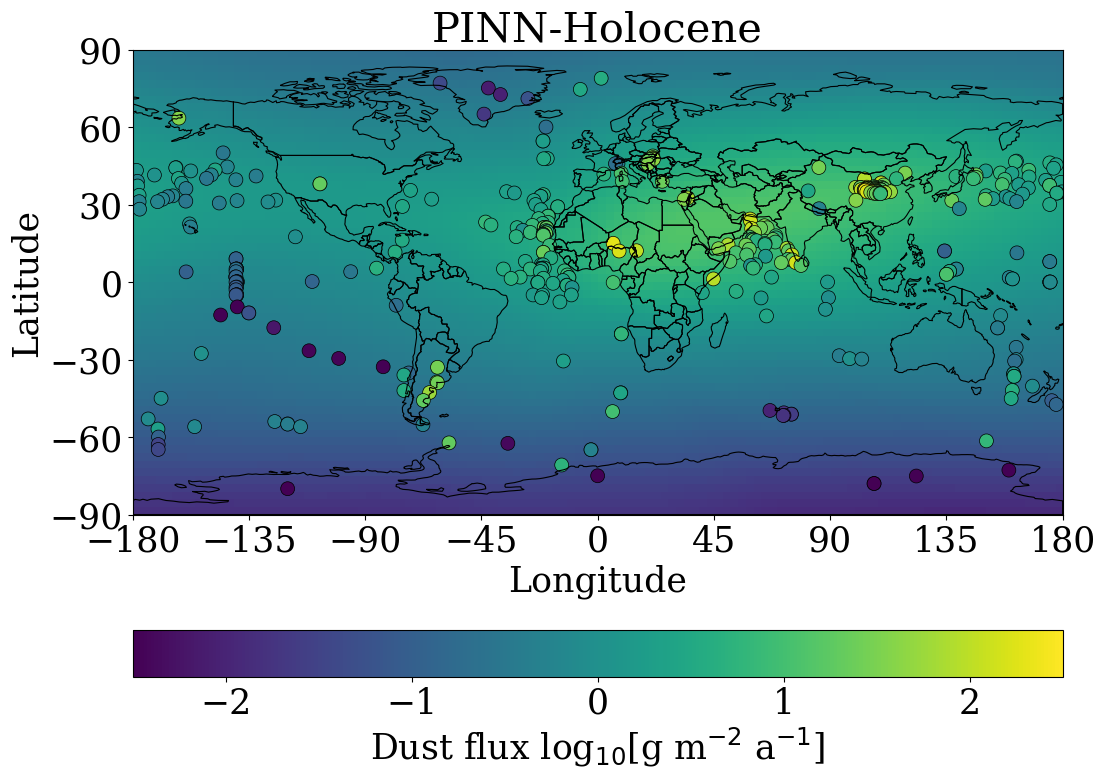

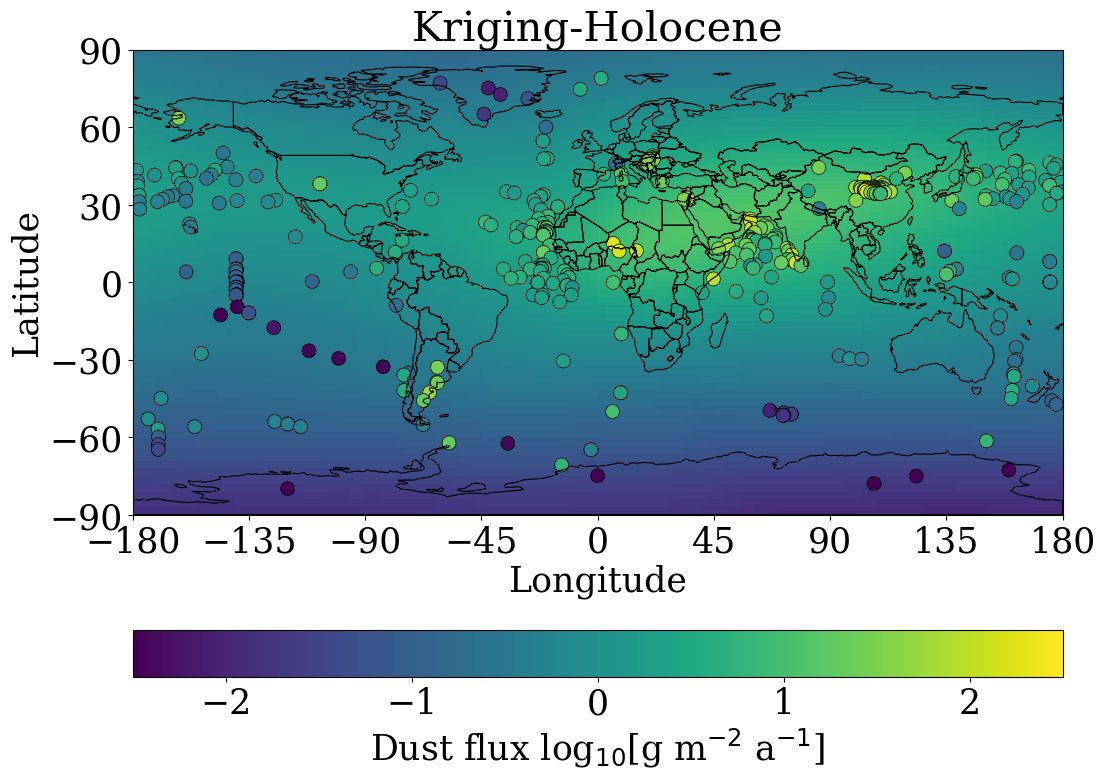

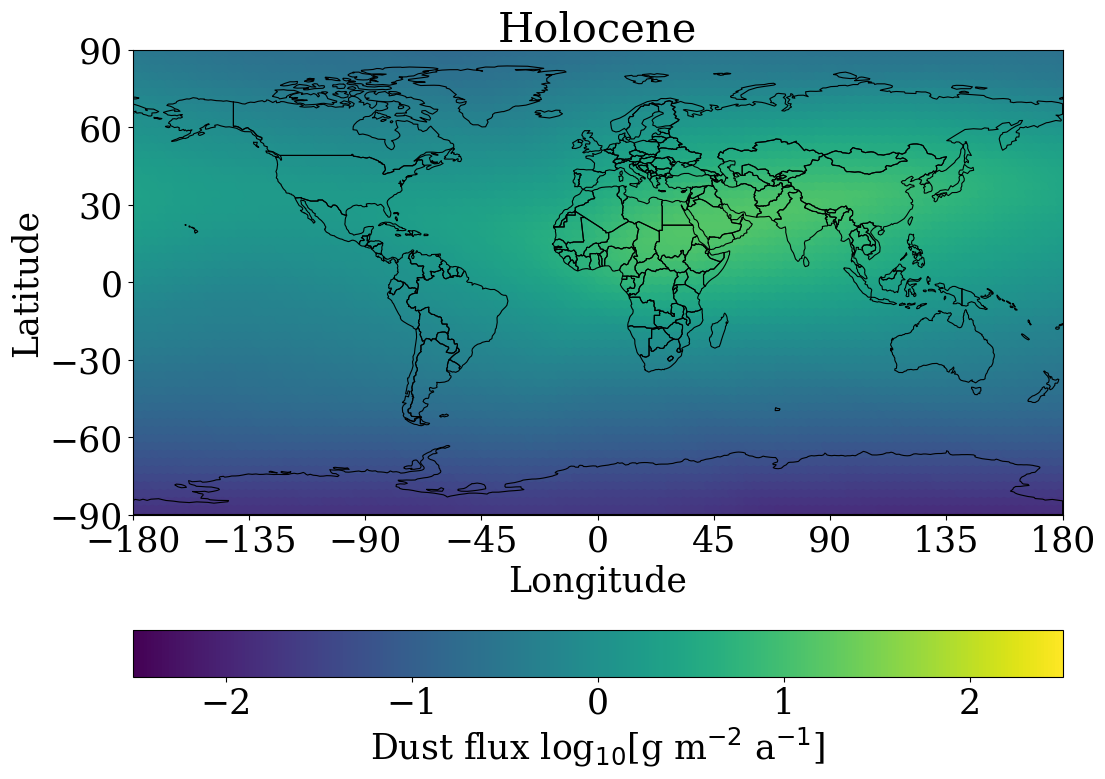

In [20]:



plot_dust_deposition_map(
    df_pinn_empirical_Holocene_global_grid,
    df_pinn_empirical_bands,
    title='PINN-Holocene',
    name_to_save='PINN_MAP_empirical_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2.5,)



plot_dust_deposition_map(
    df_kriging_empirical_global_grid,
    df_kriging_empirical_bands,
    title='Kriging-Holocene',
    name_to_save='kriging_MAP_empirical_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='Kriging_log_dep',
    limit_bar=2.5,
     )


plot_dust_deposition_simulated(
    df_pinn_empirical_Holocene_global_grid,
    title='Holocene',
    name_to_save='PINN_MAP_SIMULATED_HOLOCENE',
    figure_save_path=FIGURE_PATH,
    label_str='PINN_log_dep',
    limit_bar=2.5,
  )



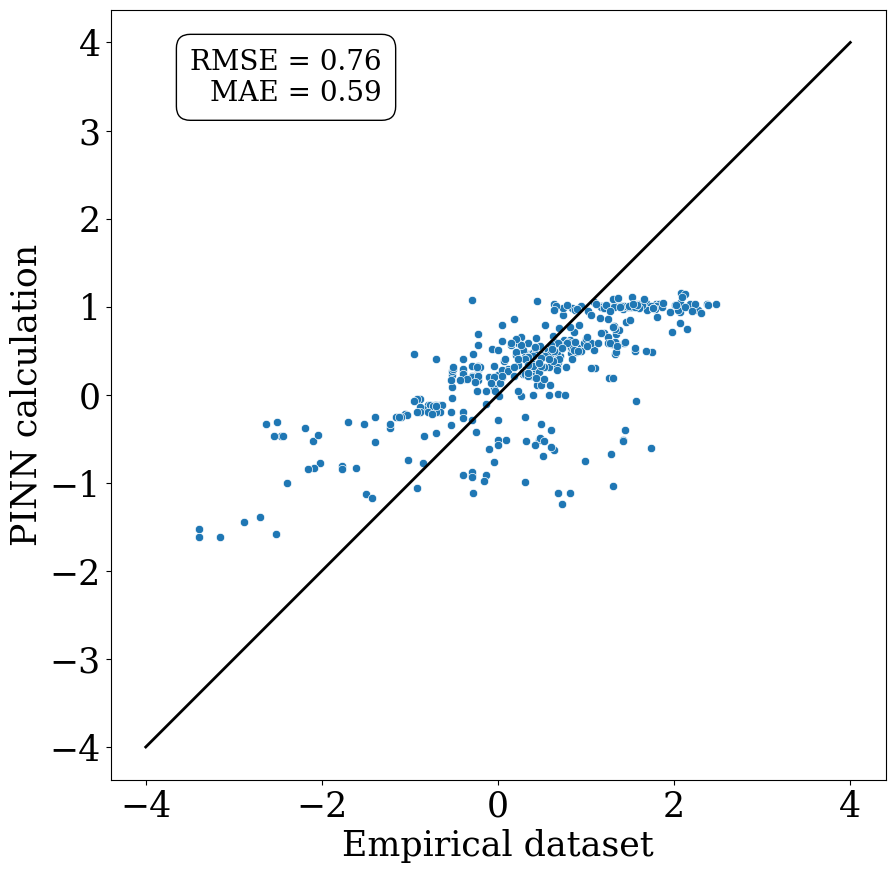

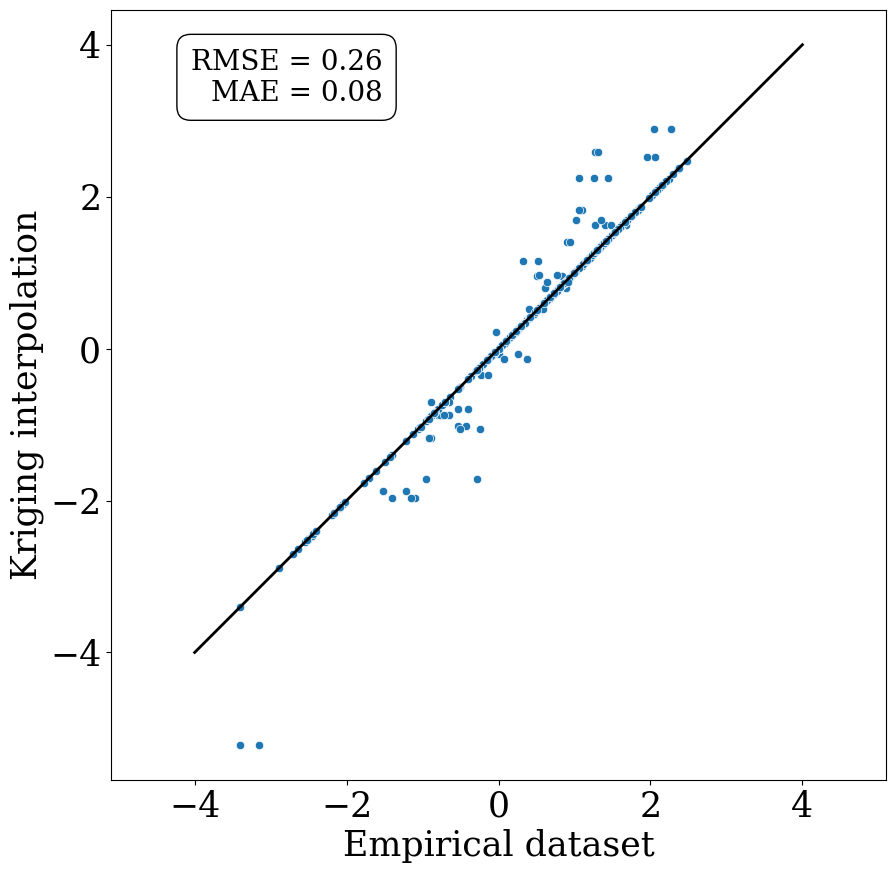

In [21]:
plot_scatterplot_empirical(
    df=df_pinn_empirical_bands,
    x_variable="log_dep",
    y_variable="PINN_log_dep",
    x_label="Empirical dataset",
    y_label="PINN calculation",
    name_to_save="SCATTER_PINN_EMPIRICAL_HOLOCENE",
    figure_save_path=FIGURE_PATH,
)

plot_scatterplot_empirical(
    df=df_kriging_empirical_bands,
    x_variable="log_dep",
    y_variable="Kriging_log_dep",
    x_label="Empirical dataset",
    y_label="Kriging interpolation",
    name_to_save="SCATTER_KRIGING_EMPIRICAL_HOLOCENE",
    figure_save_path=FIGURE_PATH,)